**Relevant reading for this problem set**:
<a href="https://moderndive.com/10-inference-for-regression.html"
target="_blank">ModernDive Chapter 10: Inference for Regression</a>.

## Background

For this problem set you will apply statistical inference to a linear
modeling and explore methods to check the required conditions. To start
we will build a model using data from the `palmerpenguins` package. The
`penguins` data contains size measurements for three penguin species
observed on three islands in the Palmer Archipelago, Antarctica.

First we will start with our typical exploratory data analysis and then
build our linear model. From there we will use our new skills to make
inferences about our regression model and check the necessary
conditions.

### Load packages

We will read the data in from the`palmerpenguins` package, explore the
data using the `dplyr` package and visualize it using the `ggplot2`
package. The `moderndive` package includes some nice functions to show
regression model outputs and finally use the `infer` package for “tidy”
and transparent statistical inference.

In [1]:
library('moderndive')
library('infer')
library('palmerpenguins')
library('tidymodels')

Warning message:
“Your system is mis-configured: ‘/var/db/timezone/localtime’ is not a symlink”
Warning message:
“‘/var/db/timezone/localtime’ is not identical to any known timezone file”
── Attaching packages ────────────────────────────────────── tidymodels 1.3.0 ──

✔ broom        1.0.8     ✔ rsample      1.3.0
✔ dials        1.4.0     ✔ tibble       3.2.1
✔ dplyr        1.1.4     ✔ tidyr        1.3.1
✔ ggplot2      3.5.2     ✔ tune         1.3.0
✔ modeldata    1.4.0     ✔ workflows    1.2.0
✔ parsnip      1.3.1     ✔ workflowsets 1.1.0
✔ purrr        1.0.4     ✔ yardstick    1.3.2
✔ recipes      1.3.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ purrr::discard() masks scales::discard()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
✖ recipes::step()  masks stats::step()



### The data

In [2]:
pen = penguins |> 
  filter(!is.na(flipper_length_mm))

In [4]:
pen |> head()

species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
<fct>,<fct>,<dbl>,<dbl>,<int>,<int>,<fct>
Adelie,Torgersen,39.1,18.7,181,3750,male
Adelie,Torgersen,39.5,17.4,186,3800,female
Adelie,Torgersen,40.3,18.0,195,3250,female
Adelie,Torgersen,36.7,19.3,193,3450,female
Adelie,Torgersen,39.3,20.6,190,3650,male
Adelie,Torgersen,38.9,17.8,181,3625,female


Take a moment to look at the data using `glimpse` and `head`. The dataset contains 8
variables. You can read more about the variables by placing your cursor in `penguins` and 
looking at the `Contextual Help` tool.

For our lab we will focus on four variables, the explanatory variables
include:

-   `flipper_length_mm` - an integer denoting flipper length
    (millimeters)
-   `bill_length_mm` - a number denoting bill length (millimeters)
-   `species`- denotes penguin species (Adélie, Chinstrap and Gentoo)

The outcome variable `body_mass_g` is an integer denoting body mass
(grams).

### Visualization

We will start by investigating the relationship between
‘flipper_length_mm’ and ‘body_mass_g’.

`geom_smooth()` using formula = 'y ~ x'


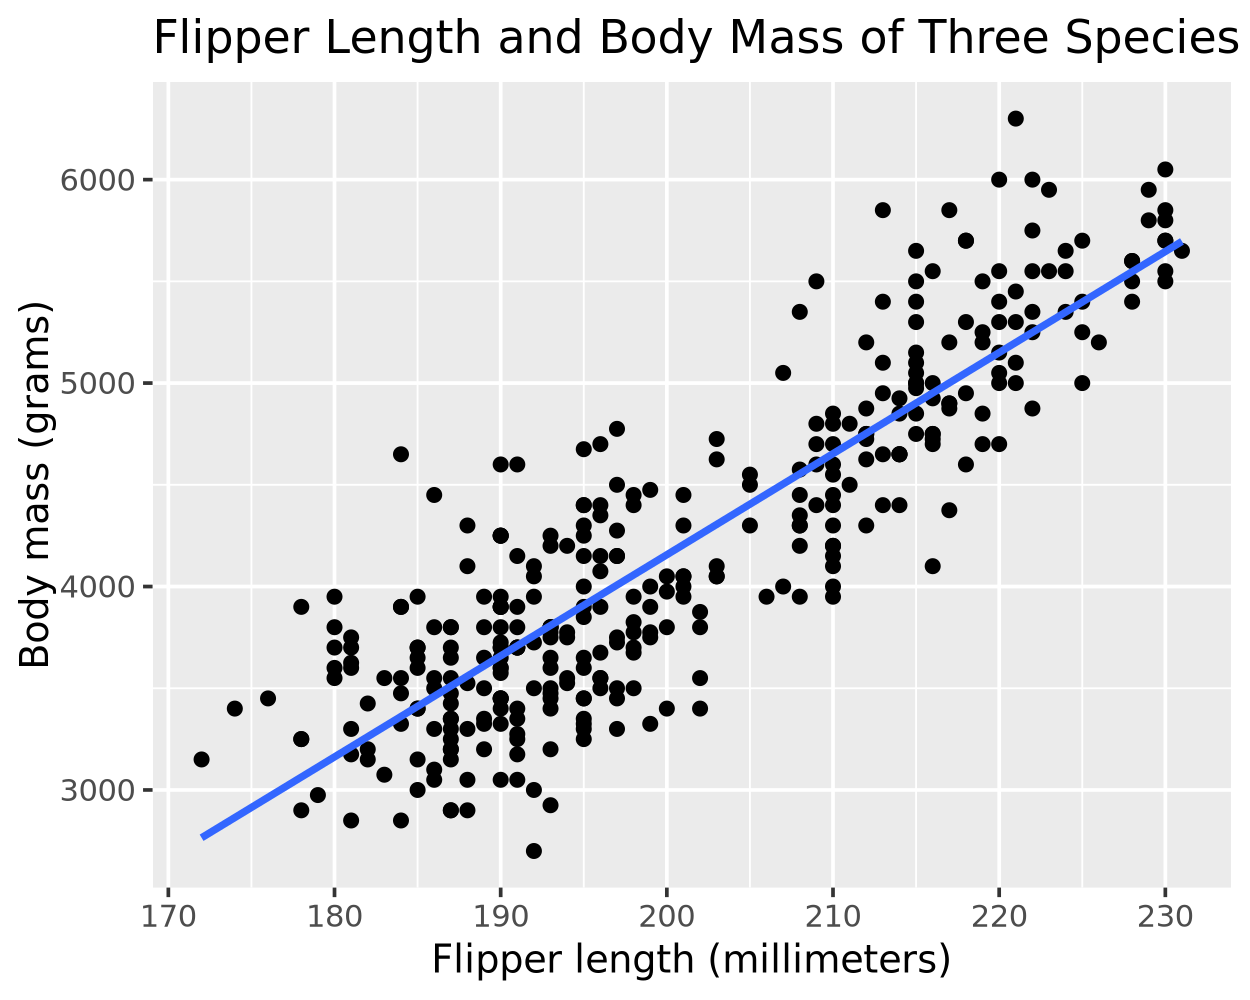

In [5]:
ggplot(data = pen, aes(y = body_mass_g, x = flipper_length_mm)) + 
  geom_point() + 
  geom_smooth(method = "lm", se = FALSE) +
  labs(x = "Flipper length (millimeters)", 
       y = "Body mass (grams)", 
       title = "Flipper Length and Body Mass of Three Species of Penguins") 

## Question 1

Does the relationship appear to be positive or negative? Does it look to
be reasonably linear?

**Answer:**  It appears to be positive. Yes, it looks reasonably linear.

## Create a linear regression model

Here we use the [standard error](https://moderndive.com/10-inference-for-regression.html#regression-se) to calculate a confidence interval. Later we will use the bootstrap resampling technique
that does not rely on distrubutional assumptions.

In [6]:
mod = linear_reg() |> set_engine('lm')

pen_model = mod |> fit(body_mass_g ~ flipper_length_mm, data = pen)

tidy(pen_model) |> mutate(lower_ci = estimate - 1.96 * std.error, upper_ci = estimate + 1.96 * std.error)

term,estimate,std.error,statistic,p.value,lower_ci,upper_ci
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-5780.83136,305.814504,-18.90306,5.587301e-55,-6380.22779,-5181.43493
flipper_length_mm,49.68557,1.518404,32.72223,4.370681e-107,46.70949,52.66164


## Question 2

Using our shorthand interpretation for confidence intervals and the
regression table, write a sentence interpreting the 95% confidence
interval for $\beta_1$?

**Answer:**

We are 95% confident that the true slope of flipper length in the penguins population is between 46.71 and 52.66.

## Question 3

Recall that the test statistic and $p$-value correspond to the
hypothesis test:

$$\begin{aligned} H_0:&\beta_{1} = 0 \\\ \mbox{vs }H_A:& \beta_{1} \neq 0 \end{aligned}$$

Write up the results & conclusions for this hypothesis test.

**Answer:**

0 is not in the range for the confidence interval for slope. Therefore, we can reject the null hypothesis that the slope = 0.

## Question 4

You may remember that this hypothesis test is only valid if certain
“conditions for inference for regression” are met. Let’s take a closer
look those conditions.

1.  Linearity of relationship between variables
2.  Independence of the residuals
3.  Normality of the residuals
4.  Equality of variance of the residuals

## Linearity of relationship between variables

**4a) ** This was analyzed in question 1. Did you say that the
relationship between `flipper_length_mm` and `body_mass_g` appears to be
linear?

**Answer:**

Yes!

## Independence of the residuals

The observations in our data must be independent of one another. In this
data, we can not be sure this is case, for example, some of the penguins
included may be related (siblings, parents). We are not given enough
information to verify this condition has been met.

## Normality of the residuals

The third condition is that the residuals should follow a Normal
distribution centered 0. To check for normality, create a histogram.

The code to get the residuals is given.

In [7]:
regression_points = augment(pen_model, new_data = pen)

regression_points |> head()

.pred,.resid,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<int>,<int>,<fct>
3212.256,537.743839,Adelie,Torgersen,39.1,18.7,181,3750,male
3460.684,339.316007,Adelie,Torgersen,39.5,17.4,186,3800,female
3907.854,-657.854091,Adelie,Torgersen,40.3,18.0,195,3250,female
3808.483,-358.482958,Adelie,Torgersen,36.7,19.3,193,3450,female
3659.426,-9.426259,Adelie,Torgersen,39.3,20.6,190,3650,male
3212.256,412.743839,Adelie,Torgersen,38.9,17.8,181,3625,female


**4b)**

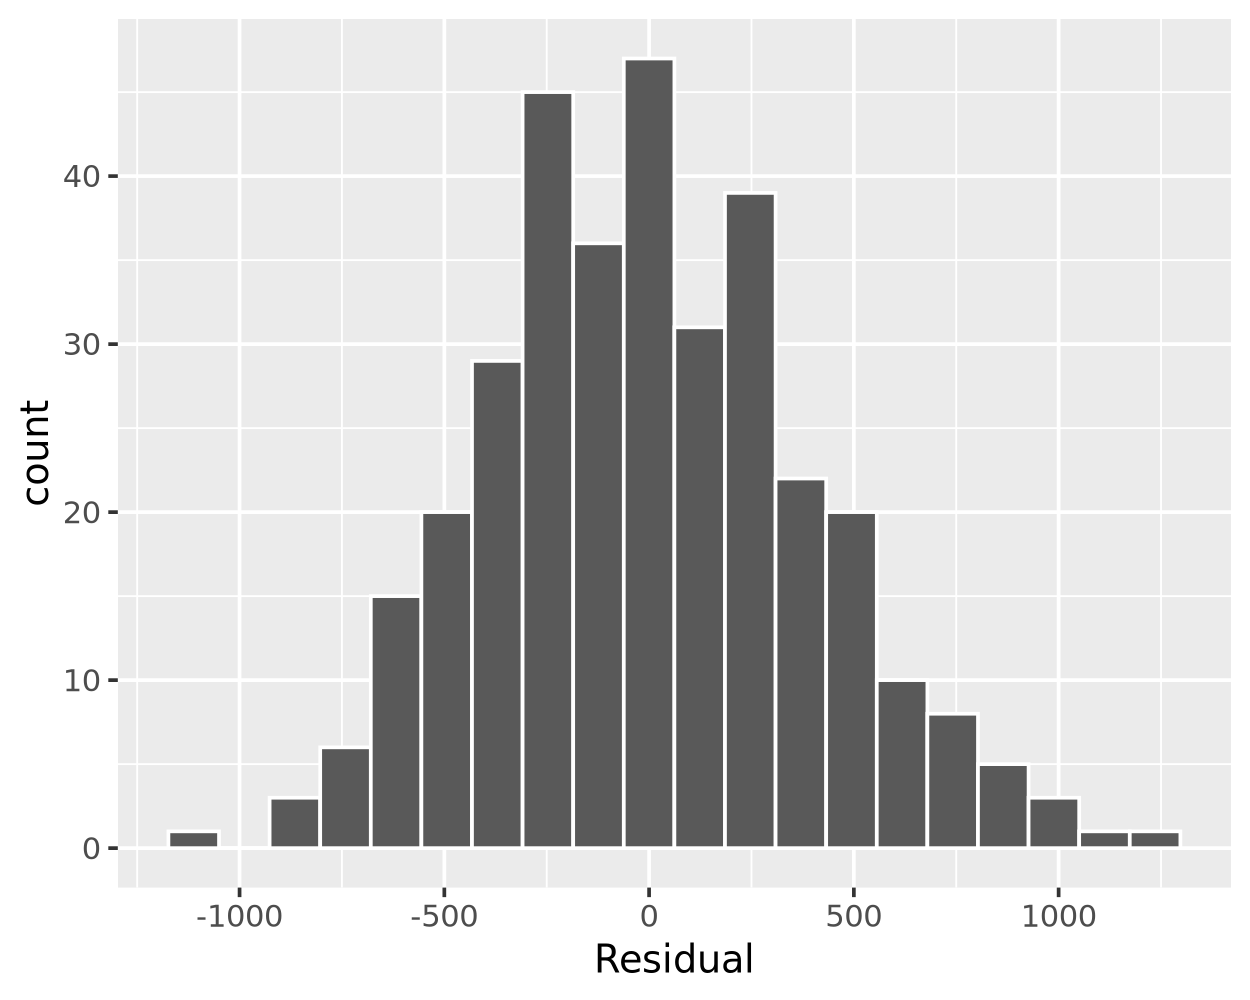

In [20]:
ggplot(regression_points, aes(x = .resid)) +
  geom_histogram(bins = 20, color = "white") +
  labs(x = "Residual")

**4c)** Does this model meet the normality of residuals condition?

**Answer:**

Yes! Looks relatively normal.

## Equality of variance of the residuals

The final condition says that the residual should exhibit equal variace
across all of the values of the explanatory variable.

To check this condition we can create a scatterplot that has our
explanatory variable, `flipper_length_mm`, on the x-axis and our
residuals on the y-axis. Does this model meet the Normality of Residuals
condition?

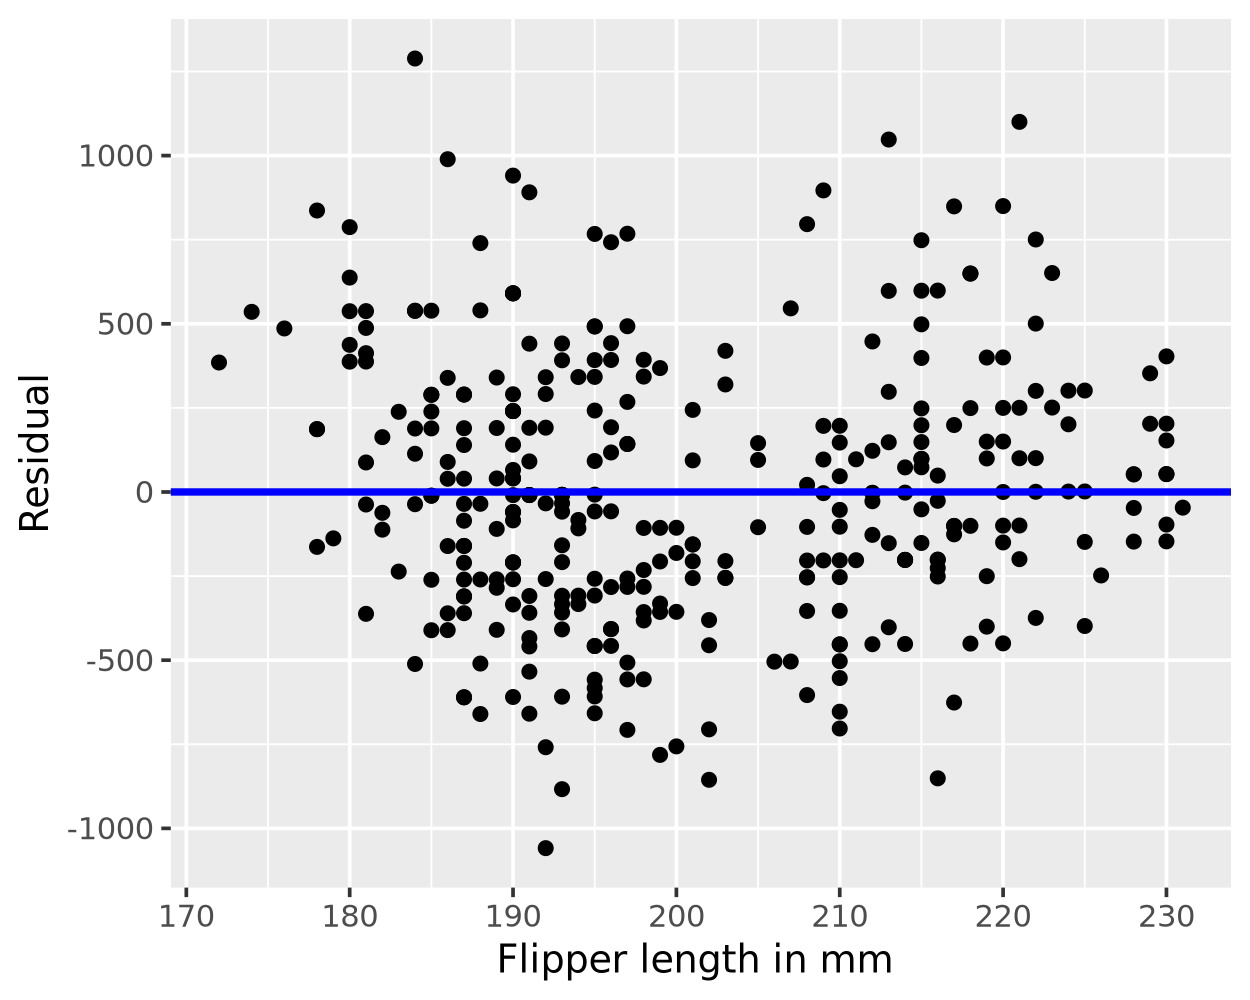

In [21]:
ggplot(regression_points, aes(x = flipper_length_mm, y = .resid)) +
  geom_point() +
  labs(x = "Flipper length in mm ", y = "Residual") +
  geom_hline(yintercept = 0, col = "blue", linewidth = 1)

**4d.** Does this model meet the equality of variance condition?

**Answer:**  Yes! The regression line is at 0 for the residuals variable.

## Question 5

Now let’s circle back and take a second look at the confidence
intervals. Using this bootstrap distribution, we’ll construct the 95%
confidence interval using the percentile method and (if appropriate) the
standard error method as well. We can compare our results to the results
from R (which uses mathematical formula to construct confidence
intervals.)

### Step 1: Calculate the bootstrap statistic and Visualize the bootstrap distribution

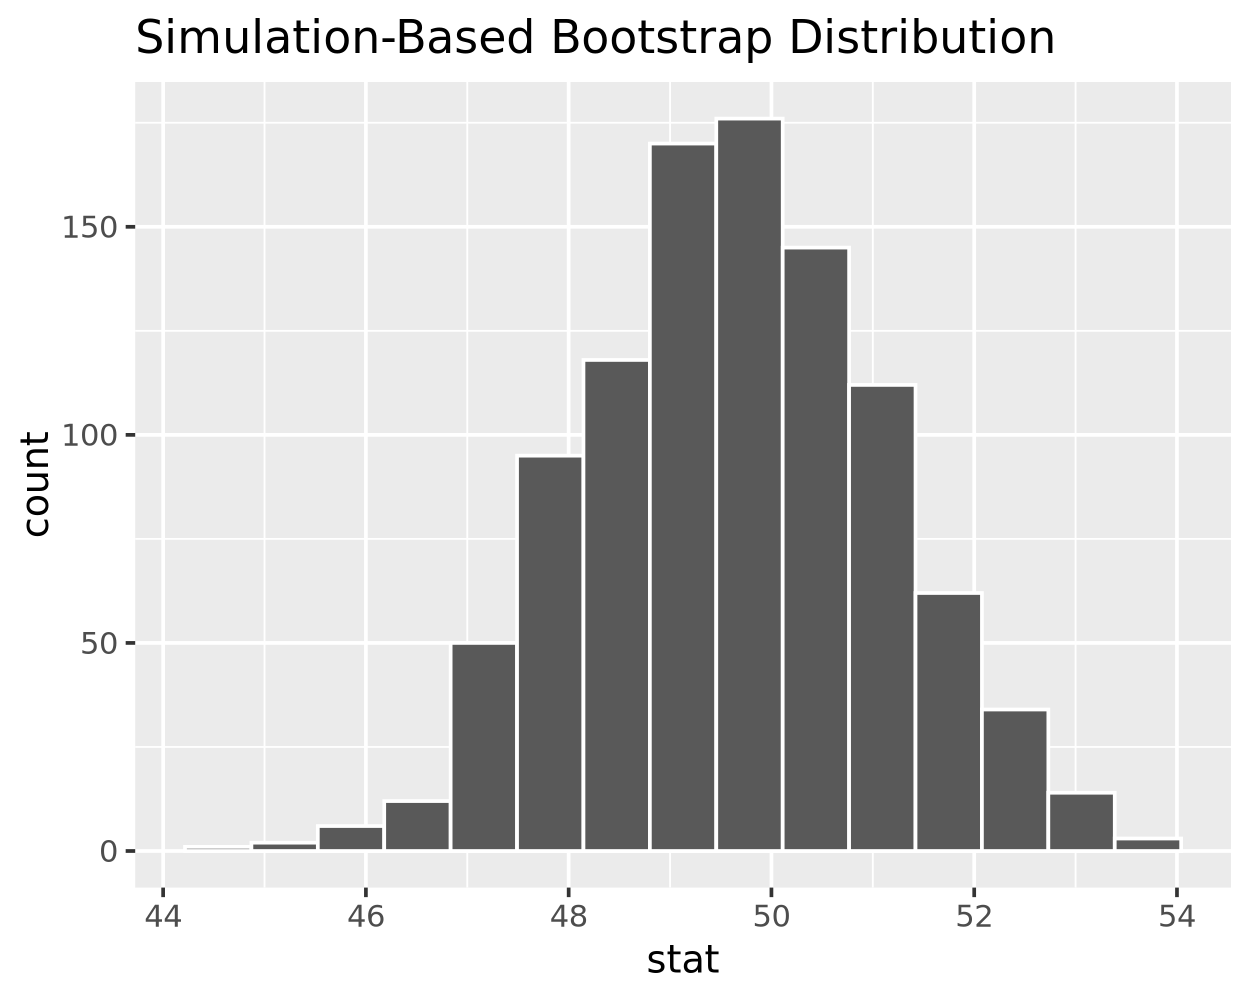

In [22]:
bootstrap_distn_slope = pen |> 
  specify(formula = body_mass_g ~ flipper_length_mm) |>
  generate(reps = 1000, type = "bootstrap") |>
  calculate(stat = "slope")

visualize(bootstrap_distn_slope)

### Step 2: Calculate CI from the a bootstap resample using the percentile method.

Find a 95% CI using percentile method:

In [23]:
slope_ci = bootstrap_distn_slope |>
    summarize(lower_ci = quantile(stat, 0.025), 
              upper_ci = quantile(stat, 0.975))

slope_ci

lower_ci,upper_ci
<dbl>,<dbl>
47.05617,52.37731


## Question 6

Write down the two 95% confidence intervals for the $\beta_{1}$. a, b,
c, and d with the appropriate values you’ve computed.

When you are done, make sure all the `|` in the table still line up so
your results print out in a table!

| CI construction method                | lower value | upper value |
|---------------------------------------|-------------|-------------|
| Using bootstrap: percentile rule      | 47.05617   | 52.37731   |
| Using mathematical formula (see [above](#Create-a-linear-regression-model)) | 46.70949  | 52.66164  |

In your opinion, would you say these three confidence intervals are
similar?

**Answers:**

Yes! Very similar.

## Part 2

For the next part you will check the conditions for regression inference
for a new model. This model will have `bill_length_mm` and `species` as
explanatory variables, and we’ll use the parallel slopes model

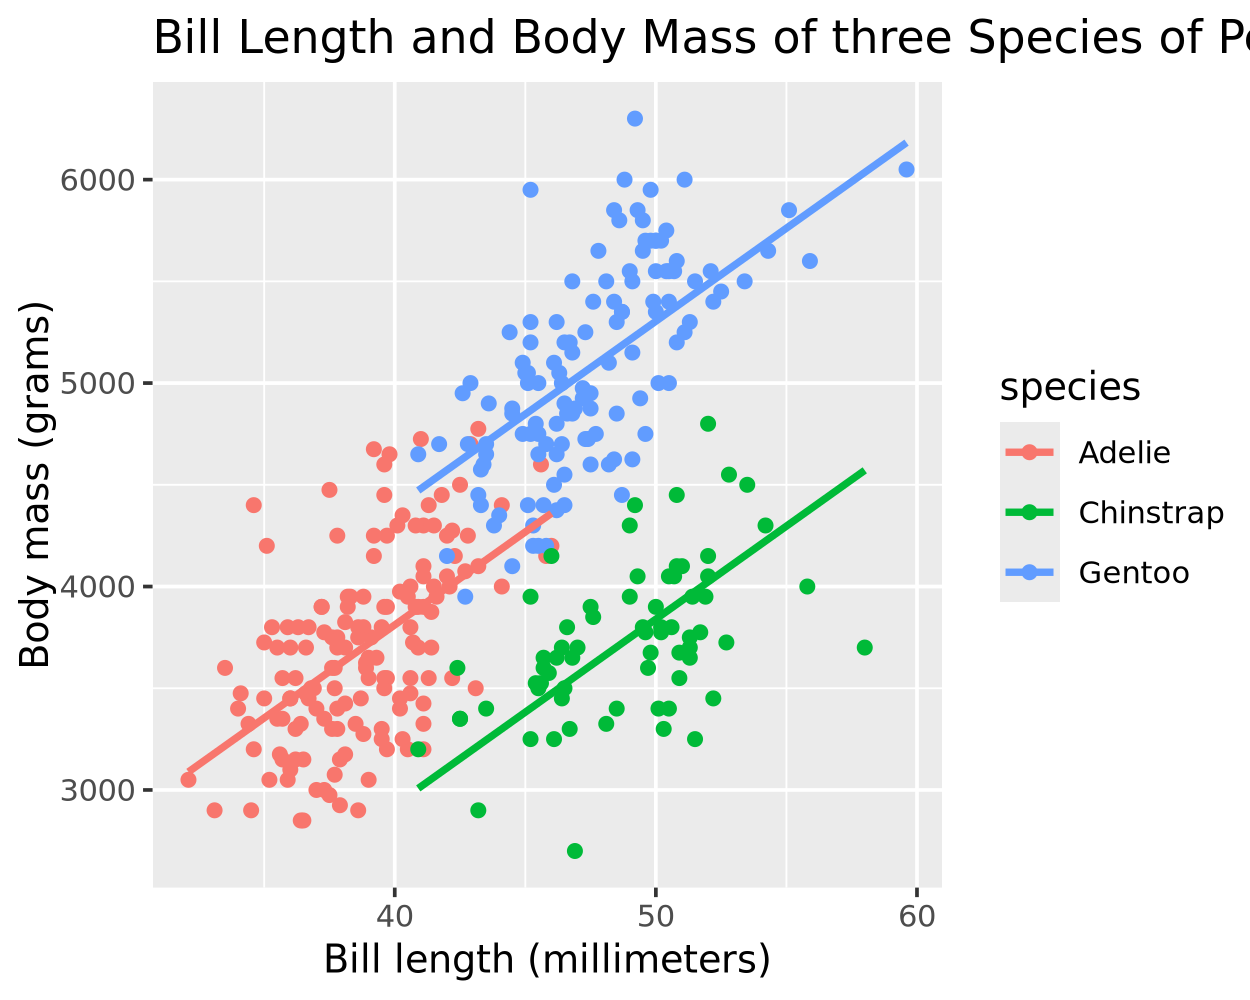

In [24]:
ggplot(data = pen, aes(y = body_mass_g, x = bill_length_mm, color=species)) + 
  geom_point() + 
  geom_parallel_slopes(se = FALSE) +
  labs(x = "Bill length (millimeters)", 
       y = "Body mass (grams)", 
       title = "Bill Length and Body Mass of three Species of Penguins") 

Let’s fit the parallel slopes model

In [25]:
# Fit regression model:

mod = linear_reg() |> set_engine('lm')

pen_parallel = mod |> fit(body_mass_g ~ bill_length_mm + species, data = pen)

# Get regression table:
tidy(pen_parallel)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),153.73969,268.901233,0.5717329,5.678829e-01
bill_length_mm,91.43582,6.887119,13.2763517,1.158990e-32
speciesChinstrap,-885.81208,88.250154,-10.0375131,6.373927e-21
speciesGentoo,578.62916,75.362341,7.6779617,1.756354e-13


Let us once again inspect the conditions necessary for inference with
regression.

1.  Linearity of relationship between variables
2.  Independence of the residuals
3.  Normality of the residuals
4.  Equality of variance of the residuals

## Question 7

**Check for Linearity of relationship between variables **

Would you say that the relationship between `bill_length_mm` and
`body_mass_g` appears to be linear for each species?

**Answer:**

Yes

**Check for Independence of the residuals **

This is the same as the first model that we looked it. The observations
in our data must be independent of one another. In this data, we can not
be sure this is case, for example, some of the penguins included may be
related (siblings, parents). We are not given enough information to
verify this condition has been met.

## Question 8

Check Normality of the residuals (and they should be centered at 0.)

**8a)**

In [28]:
regression_points2 = augment(pen_parallel, new_data = pen)

regression_points2 |> head()

.pred,.resid,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<int>,<int>,<fct>
3728.880,21.11981,Adelie,Torgersen,39.1,18.7,181,3750,male
3765.455,34.54548,Adelie,Torgersen,39.5,17.4,186,3800,female
3838.603,-588.60318,Adelie,Torgersen,40.3,18.0,195,3250,female
3509.434,-59.43423,Adelie,Torgersen,36.7,19.3,193,3450,female
3747.167,-97.16736,Adelie,Torgersen,39.3,20.6,190,3650,male
3710.593,-85.59303,Adelie,Torgersen,38.9,17.8,181,3625,female


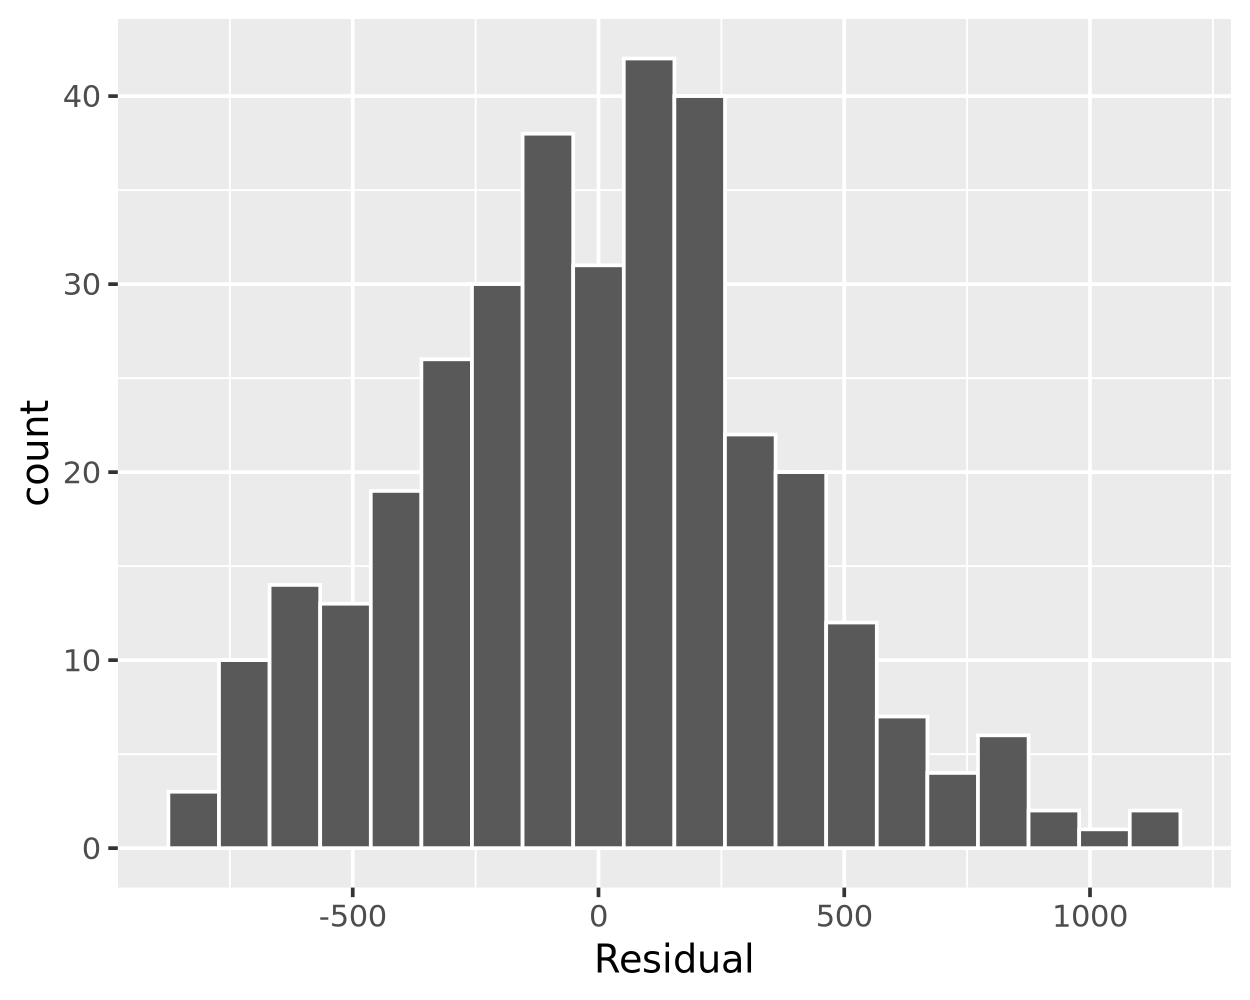

In [29]:
#Add code for the histogram:

ggplot(regression_points2, aes(x = .resid)) +
  geom_histogram(bins = 20, color = "white") +
  labs(x = "Residual")

**8b)** Does this model meet the Normality of Residuals condition?

**Answer:**

Yes; it's centered at 0

## Question 9

Check for Equality of variance of the residuals

To check this condition we can create a scatterplot that has our
explanatory variable, `flipper_length_mm`, on the x-axis and our
residuals on the y-axis.

**9a)**

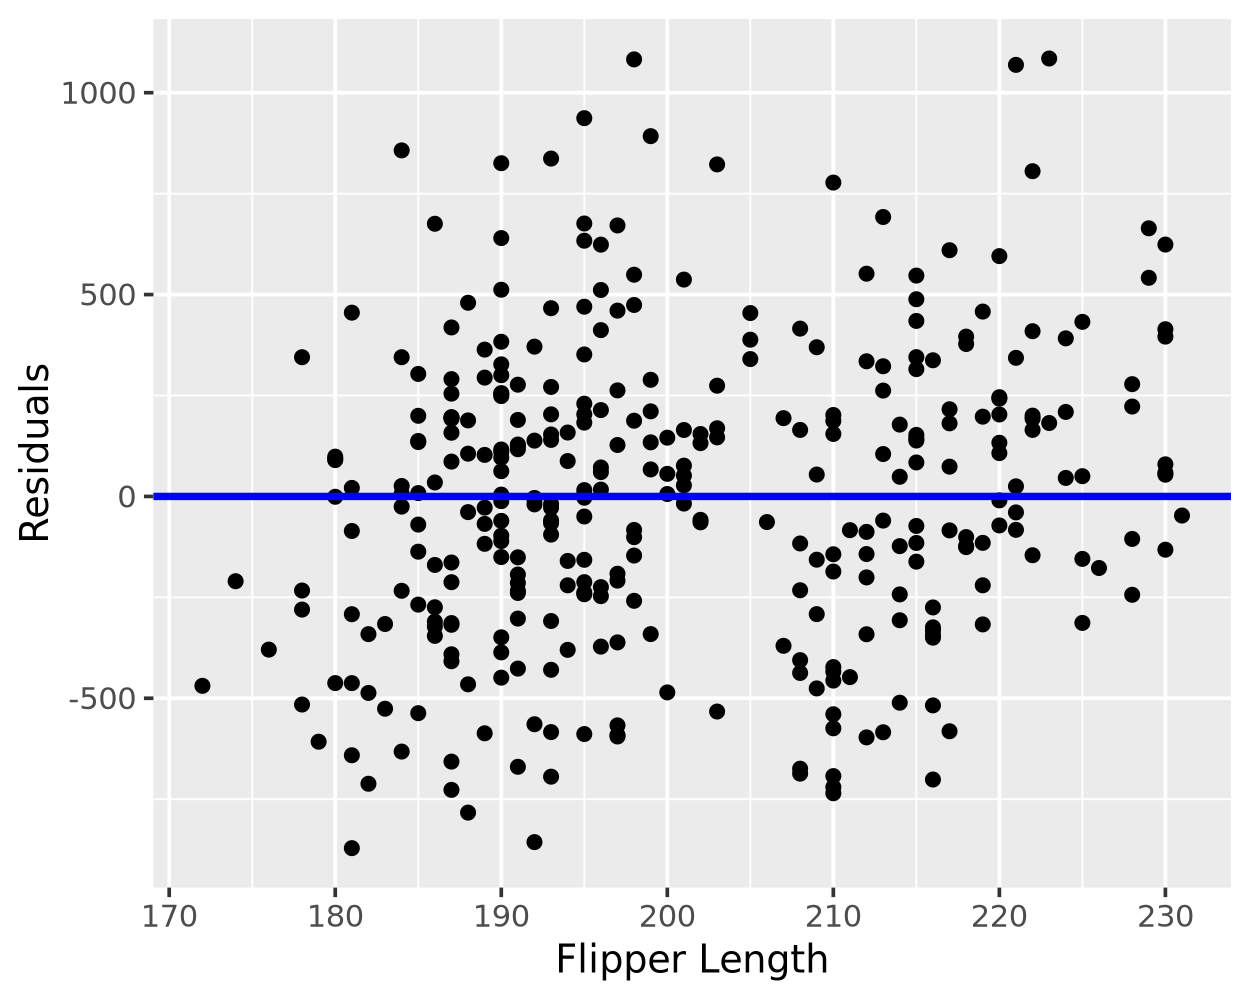

In [34]:
ggplot(regression_points2, aes(y = .resid, x = flipper_length_mm)) +
    geom_point() + 
    labs(x = "Flipper Length",
         y = "Residuals") +
    geom_hline(yintercept = 0, col = 'blue', linewidth = 1)

**9b)** Does this meet the equality of variance of the residuals
condition?

**Answer:**

Yes because the spread of the residuals around the line y = 0 is constant.

## Question 10

Run the code below to find the confidence intervals for our model's coefficients.

In [35]:
boots = bootstraps(pen, times = 1000, apparent = TRUE)

mod = linear_reg() |> set_engine('lm')

boot_models  = boots |> 
  mutate(model = map(splits, ~mod |> fit(body_mass_g ~ bill_length_mm + species, data = as_tibble(.x))),
         coef_info = map(model, tidy))

boot_coefs = boot_models |> 
  unnest(coef_info)

percentile_intervals = int_pctl(boot_models, coef_info)

percentile_intervals

term,.lower,.estimate,.upper,.alpha,.method
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
(Intercept),-362.50144,142.47578,623.3176,0.05,percentile
bill_length_mm,79.46032,91.73977,104.5651,0.05,percentile
speciesChinstrap,-1040.83356,-890.65199,-746.1113,0.05,percentile
speciesGentoo,437.72610,576.32252,717.5376,0.05,percentile


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


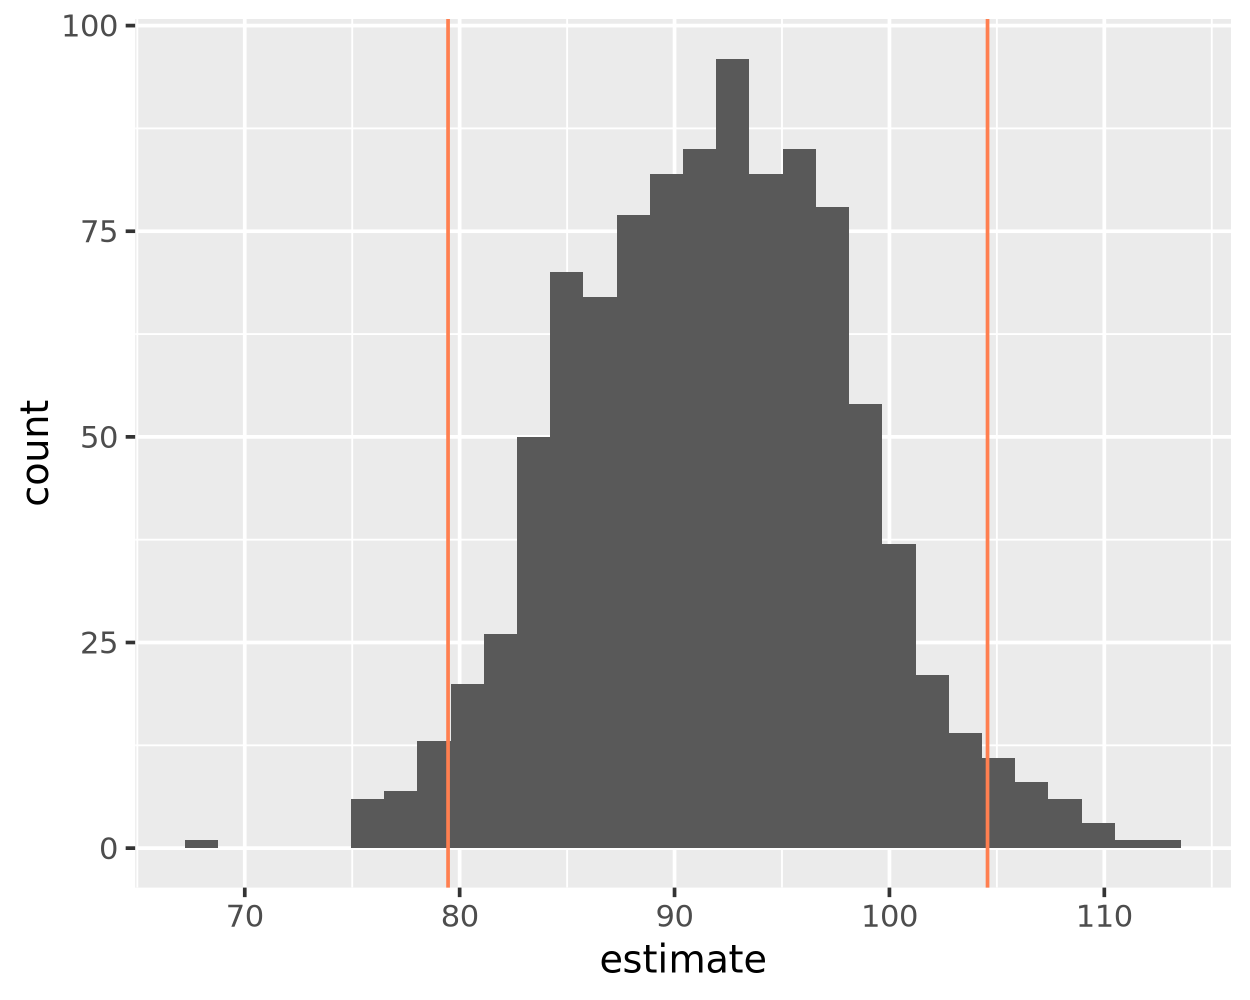

In [36]:
boot_coefs |> 
    filter(term == 'bill_length_mm') |>
ggplot(aes(x = estimate)) +
    geom_histogram() +
    geom_vline(xintercept = percentile_intervals |> filter(term == 'bill_length_mm') |> pull(.lower), color = 'coral') +
    geom_vline(xintercept = percentile_intervals |> filter(term == 'bill_length_mm') |> pull(.upper), color = 'coral')

What can we conclude about the relationship between bill length and body
mass?

**Answer:**

We can conclude that there is a positive relationship between bill length and body mass for all three species. We are 99% confident that the true slope of bill length in the penguins population for all 3 species for parallel slopes is between 79.46 and 104.57.